In [1]:
import torch
import numpy as np
import argparse
from datasets import create_dataset
from models import create_model
from tqdm import tqdm
from matplotlib import pyplot as plt
import matplotlib.animation as animation

### Util functions

In [2]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def pyplot_skeleton(topology, offsets):
    # Plot a skeleton in 3d
    plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    total_offsets = torch.zeros_like(offsets)
#     print("total offset: ", total_offsets.shape)
    for j, i in enumerate(topology):
#         print("i: {}, j: {}".format(i, j))
        total_offsets[j] = offsets[j] + total_offsets[i]
        plt.plot(
            np.array(total_offsets[[i,j], 0]), 
            np.array(total_offsets[[i,j], 2]), 
            np.array(total_offsets[[i,j], 1]), 
            color='black'
            )
    set_axes_equal(ax)

### Parameters

In [3]:
args = argparse.Namespace()
args.save_dir='./pretrained/' 
args.num_layers=2
args.downsampling='stride2'
args.batch_normalization=0
args.upsampling='linear'
args.activation='LeakyReLU'
args.kernel_size=15
args.base_channel_num=-1
args.normalization=1
args.skeleton_dist=2
args.verbose=1
args.learning_rate=2e-4
args.skeleton_pool='mean'
args.data_augment=0
args.padding_mode='reflection'
args.batch_size=256
args.debug=0
args.skeleton_info='concat'
args.patch_gan=1
args.fk_world=0
args.eval=1
args.ee_loss='vec'
args.ee_loss_fact='learn'
args.pos_repr='3d'
args.model='mul_top_mul_ske'
args.ee_velo=1
args.rec_loss_mode='extra_global_pos'
args.simple_operator=0
args.epoch_num=30000
args.gan_mode='lsgan'
args.lambda_ee=100
args.alpha=0
args.epoch_num=20001
args.window_size=64
args.extra_conv=0
args.dataset='Mixamo'
args.D_global_velo=0
args.pool_size=50
args.epoch_begin=0
args.lambda_rec=5
args.lambda_cycle=5
args.lambda_ee=100
args.lambda_global_pose=2.5
args.lambda_position=1
args.ee_from_root=1
args.scheduler='none'
args.adaptive_ee=0
args.use_sep_ee=0
args.eval_seq=0

args.cuda_device='cpu'
args.is_train = False
args.rotation = 'quaternion'


### Transfer Mixamo animations to the Poppy skeleton

In [7]:
# We have defined a skeleton of group A for the Poppy robot (in file Mixamo/std_bvhs/Poppy.bvh)
character_names = [['Aj', 'Poppy']]

dataset = create_dataset(args, character_names)

# # Plot the default pose skeleton of Poppy
# pyplot_skeleton(dataset.joint_topologies[0], dataset.offsets[0][1])

model = create_model(args, character_names, dataset)
model.load(epoch=20000)

motion_id = 0

motions = [
    [dataset.get_item(0, 0, motion_id).unsqueeze(0), [0]]
]
model.set_input(motions)

model.latents = []
model.offset_repr = []
model.pos_ref = []
model.ee_ref = []
model.res = []
model.res_denorm = []
model.res_pos = []
model.fake_res = []
model.fake_res_denorm = []
model.fake_pos = []
model.motions = []
model.motion_denorm = []
model.rnd_idx = []

model.offset_repr.append(model.models[0].static_encoder(model.dataset.offsets[0]))

# We take as source the first skeleton "Aj"
src_id = 0
dst_id = 1
src_topology_id = 0
dst_topology_id = 0

# Find the motions in the dataset
motion, _ = model.motions_input[src_id]
motion = motion.to(model.device)
motion = model.dataset.normalize(src_topology_id, [src_id], motion)

# Load the offsets
src_offsets_repr = [model.offset_repr[src_topology_id][p][[src_id]] for p in range(model.args.num_layers + 1)]
dst_offsets_repr = [model.offset_repr[dst_topology_id][p][[dst_id]] for p in range(model.args.num_layers + 1)]
# print("src_offsets_repr: ", src_offsets_repr)

# Compute the latent representation with the source encoder

# Compute the reconstruction using the destination decoder
latent, res = model.models[src_topology_id].auto_encoder(motion, src_offsets_repr)

# Retargeting
fake_res = model.models[dst_topology_id].auto_encoder.dec(latent, dst_offsets_repr)

# Denormalize and use FK on all motions
motion_denorm = model.dataset.denorm(src_id, [src_id], motion)
print(motion_denorm)
pos = model.models[src_topology_id].fk.forward_from_raw(motion_denorm, model.dataset.offsets[src_topology_id][[src_id]]).detach()
print( model.models[src_topology_id].edges)
print( model.models[src_topology_id].fk.rotation_map)
res_denorm = model.dataset.denorm(src_topology_id, [src_id], res)
res_pos = model.models[src_topology_id].fk.forward_from_raw(res_denorm, model.dataset.offsets[src_topology_id][[src_id]]).detach()

fake_res_denorm = model.dataset.denorm(dst_topology_id, [dst_id], fake_res)
fake_pos = model.models[dst_topology_id].fk.forward_from_raw(fake_res_denorm, model.dataset.offsets[dst_topology_id][[dst_id]]).detach()

file path:./datasets/Mixamo/std_bvhs/Aj.bvh, skeleton type: 0
file path:./datasets/Mixamo/std_bvhs/Poppy.bvh, skeleton type: 0
file path:./datasets/Mixamo/std_bvhs/Aj.bvh, skeleton type: 0
file path:./datasets/Mixamo/std_bvhs/Aj.bvh, skeleton type: 0
file path:./datasets/Mixamo/std_bvhs/Poppy.bvh, skeleton type: 0
file path:./datasets/Mixamo/std_bvhs/Poppy.bvh, skeleton type: 0
file path:./datasets/Mixamo/std_bvhs/Aj.bvh, skeleton type: 0
file path:./datasets/Mixamo/std_bvhs/Poppy.bvh, skeleton type: 0
loading from ./pretrained/models\topology0
loading from epoch 20000......
load succeed!
combined_motion, file_path:  ./datasets/Mixamo/Aj/Baseball Pitching.bvh
file path:./datasets/Mixamo/Aj/Baseball Pitching.bvh, skeleton type: 0
tensor([[[ 7.4994e-01,  7.4997e-01,  7.5004e-01,  ...,  7.3992e-01,
           7.4134e-01,  7.4334e-01],
         [-9.0602e-03, -9.2976e-03, -9.4098e-03,  ..., -1.3058e-02,
          -1.3331e-02, -1.3507e-02],
         [-6.6100e-01, -6.6096e-01, -6.6086e-01,  .

In [27]:
print(dataset.joint_topologies)

[(0, 0, 1, 2, 3, 0, 5, 6, 7, 0, 9, 10, 11, 12, 13, 12, 15, 16, 17, 12, 19, 20, 21)]


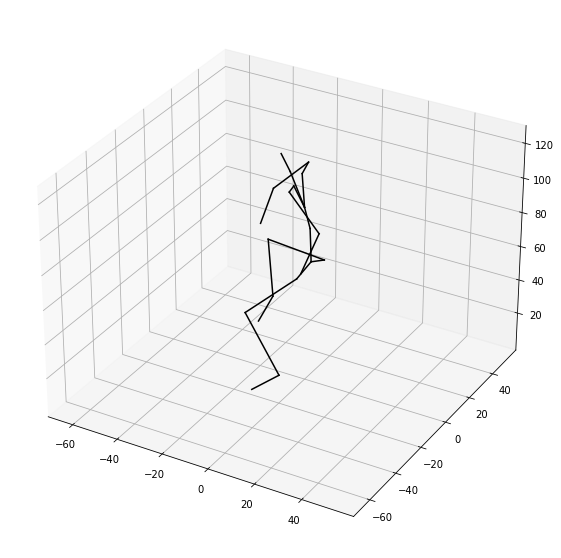

In [28]:
pyplot_skeleton(dataset.joint_topologies[0], pos[0, 40])

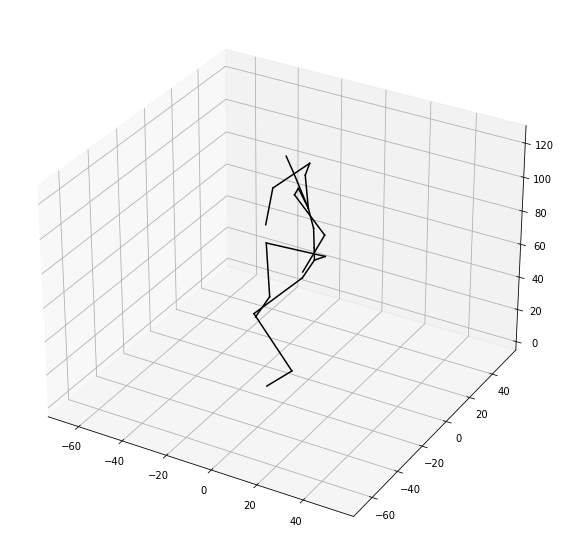

In [29]:
pyplot_skeleton(dataset.joint_topologies[0], res_pos[0, 40])

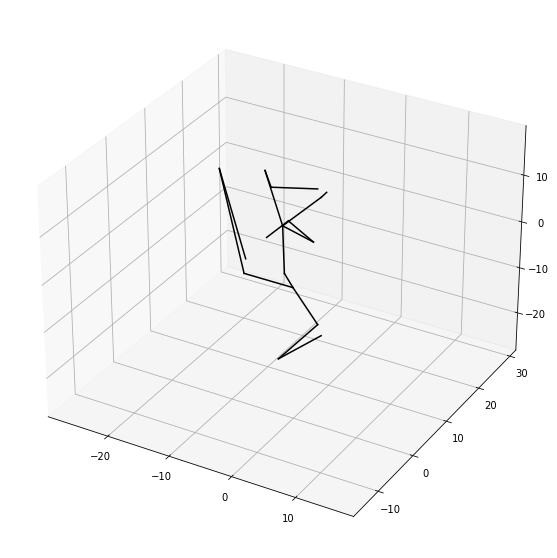

In [30]:
pyplot_skeleton(dataset.joint_topologies[0], fake_pos[0, 40])
# fake_pos[0,41]

In [33]:
def draw_3Danimation(topology, a_pos, save_path):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    
    def init(topology, offsets):
        lines = []
        total_offsets = np.zeros_like(offsets)
        for j, i in enumerate(topology):
    #         print("i: {}, j: {}".format(i, j))
            total_offsets[j] = offsets[j] + total_offsets[i]
            stick_line = ax.plot(total_offsets[[i,j], 0], total_offsets[[i,j], 2], 
                total_offsets[[i,j], 1])[0]
            stick_line._verts3d = total_offsets[[i,j], 0], total_offsets[[i,j], 2], total_offsets[[i,j], 1]
            lines.append(stick_line)
        return lines

    def draw_animation_skeleton(i, topology, all_offsets, lines):
        # Plot a skeleton in 3d
        offsets = all_offsets[0, i]
        total_offsets = np.zeros_like(offsets)
    #     print("total offset: ", total_offsets.shape)
        for j, i in enumerate(topology):
    #         print("i: {}, j: {}".format(i, j))
            total_offsets[j] = offsets[j] + total_offsets[i]
            lines[j]._verts3d = total_offsets[[i,j], 0], total_offsets[[i,j], 2], total_offsets[[i,j], 1]
        set_axes_equal(ax)
        return lines
    
#     poppy_topology = dataset.joint_topologies[0]
    lines = init(topology, a_pos[0,0])
    total_len = a_pos.shape[1]
    # poppy_lines
    anim = animation.FuncAnimation(fig = fig, func = draw_animation_skeleton, 
                                   frames = total_len, fargs = (topology, a_pos, lines), blit = True)
    anim.save(save_path)

MovieWriter ffmpeg unavailable; using Pillow instead.


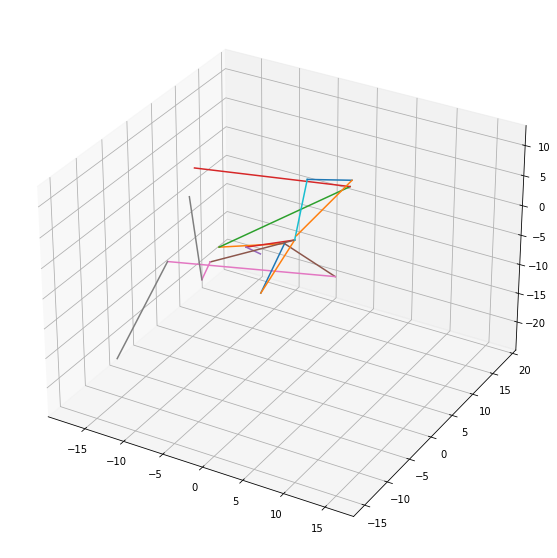

In [35]:
print()
# fake_pos = fake_pos.numpy()
draw_3Danimation(dataset.joint_topologies[0], fake_pos, "poppy.gif")
# draw_3Danimation(dataset.joint_topologies[0], pos, "Aj.gif")

In [ ]:
# for i in range(100):
#     pyplot_skeleton(dataset.joint_topologies[0], fake_pos[0, i])
#     plt.pause(0.01)
# plt.show()
# aTry = pos[0,40]
# print(aTry)
# aTry[[1,3],0]

### Run poppy real IK to obtain the poppy joint angle positions


# TODO

### Simulate the obtained trajectories on VREP

# TODO